# Instructions

## 1. Device Setup

In [ ]:
from laboneq.simple import SHFQC
from laboneq.dsl.device import DeviceSetup, create_connection
import numpy as np
from copy import deepcopy


#instantiate ad device setup object
setup = DeviceSetup(uid="test_setup")
#add a dataserver
setup.add_dataserver(host=host, port="8004",uid="test_server")

setup.add_instruments(SHFQC(uid="test_shfqc",server_uid="test_server", address="DEV12576", device_options="SHFQC/PLUS/QC6CH"))

setup.instruments

[SHFQC(
│   uid='test_shfqc',
│   interface='1GbE',
│   connections=[],
│   server_uid='test_server',
│   address='DEV12576',
│   device_options='SHFQC/PLUS/QC6CH',
│   reference_clock_source=None,
│   device_class=0
)
]

In [2]:
for ch_idx, q_idx in enumerate([15,16,17,18,19]):# enumerate 안에 len(list) 강제하고싶음
    #QA
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/measure", ports="QACHANNELS/0/OUTPUT")) #signal_type="iq"
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/acquire", ports="QACHANNELS/0/INPUT" )) #signal_type="acquire"
    #SG
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive", ports=f"SGCHANNELS/{ch_idx}/OUTPUT")) #signal_type="iq" only iq allowed for SG??
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive_ef", ports=f"SGCHANNELS/{ch_idx}/OUTPUT")) #signal_type="iq" only iq allowed for SG??
    setup.add_connections(
        "test_shfqc",
        create_connection(to_signal=f"q{q_idx}/drive_cr", ports=f"SGCHANNELS/{ch_idx}/OUTPUT"))#signal_type="iq"


In [3]:
setup.logical_signal_groups

{'q15': LogicalSignalGroup(
│   uid='q15',
│   logical_signals={
│   │   'measure': LogicalSignal(
│   │   │   uid='q15/measure',
│   │   │   direction=IODirection.OUT,
│   │   │   name='measure',
│   │   │   calibration=None,
│   │   │   path='/logical_signal_groups/q15/measure',
│   │   │   physical_channel=PhysicalChannel(
│   │   │   │   uid='test_shfqc/qachannels_0_output',
│   │   │   │   name='qachannels_0_output',
│   │   │   │   type=<PhysicalChannelType.IQ_CHANNEL: 'iq_channel'>,
│   │   │   │   path='/physical_channel_groups/test_shfqc/qachannels_0_output',
│   │   │   │   calibration=None
│   │   │   )
│   │   ),
│   │   'acquire': LogicalSignal(
│   │   │   uid='q15/acquire',
│   │   │   direction=IODirection.IN,
│   │   │   name='acquire',
│   │   │   calibration=None,
│   │   │   path='/logical_signal_groups/q15/acquire',
│   │   │   physical_channel=PhysicalChannel(
│   │   │   │   uid='test_shfqc/qachannels_0_input',
│   │   │   │   name='qachannels_0_input',
│   │   │

In [4]:
setup.get_calibration()

Calibration(
│   calibration_items={
│   │   '/logical_signal_groups/q15/measure': None,
│   │   '/logical_signal_groups/q15/acquire': None,
│   │   '/logical_signal_groups/q15/drive': None,
│   │   '/logical_signal_groups/q15/drive_ef': None,
│   │   '/logical_signal_groups/q15/drive_cr': None,
│   │   '/logical_signal_groups/q16/measure': None,
│   │   '/logical_signal_groups/q16/acquire': None,
│   │   '/logical_signal_groups/q16/drive': None,
│   │   '/logical_signal_groups/q16/drive_ef': None,
│   │   '/logical_signal_groups/q16/drive_cr': None,
│   │   '/logical_signal_groups/q17/measure': None,
│   │   '/logical_signal_groups/q17/acquire': None,
│   │   '/logical_signal_groups/q17/drive': None,
│   │   '/logical_signal_groups/q17/drive_ef': None,
│   │   '/logical_signal_groups/q17/drive_cr': None,
│   │   '/logical_signal_groups/q18/measure': None,
│   │   '/logical_signal_groups/q18/acquire': None,
│   │   '/logical_signal_groups/q18/drive': None,
│   │   '/logical_signal_grou

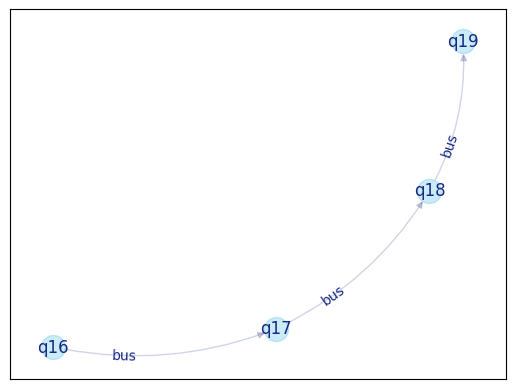

In [ ]:
from operations import TransmonOperations
from qpu_types.transmon import TransmonQubit, TransmonQubitParameters
from helper import load_qubit_parameters, save_qubit_parameters


from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from laboneq.dsl.quantum.qpu import QuantumElement

# # #TODO load_qubit_parameters should return list with TransmonQubit, currently it's a dict 
_loaded_qubits = load_qubit_parameters(filename="latest") 
loaded_qubits = list(_loaded_qubits.values())
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters")
#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 
qubits = loaded_qubits
quantum_operations = TransmonOperations()
################################################################################################
qpu = QPU(quantum_elements=qubits, quantum_operations=quantum_operations)
qpu.topology.add_edge("bus", "q16", "q17")
qpu.topology.add_edge("bus", "q17", "q18")
qpu.topology.add_edge("bus", "q18", "q19")
qpu.topology.plot()

# Create a demonstration QuantumPlatform for a transmon QPU:
quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)


from laboneq.simple import workflow
from pathlib import Path


# Two Types of store in workflow!
 
folder_store = workflow.logbook.FolderStore("/experiment_store") 
#folder_store.activate()
folder_store.deactivate()
workflow.logbook.LoggingStore().deactivate()
#workflow.logbook.LogbookStore().deactivate()


### Initial Setting

In [6]:
for _, qubit in enumerate(qubits):
    ##################LOCAL OSCILLATOR FREQUENCY AND CHANNEL POWER ###################################
    qubit.parameters.drive_lo_frequency = 4.8e9
    qubit.parameters.readout_lo_frequency = 7.0e9
    qubit.parameters.readout_range_in =  0
    qubit.parameters.readout_range_out = -25
    qubit.parameters.drive_range = 0 
    
    
    
    ############READOUT PARAMETERS###################################################################
    qubit.parameters.readout_length - 2.0e-6
    qubit.parameters.readout_pulse['function'] = 'GaussianSquare'
    qubit.parameters.readout_pulse['sigma'] = 0.1
    qubit.parameters.readout_pulse['width'] = None
    qubit.parameters.readout_pulse['risefall_sigma_ratio'] = 3.0
    qubit.parameters.readout_amplitude = 1.0  #WARNING! 이거 SWEEP 할때 오버라이딩이 안되고 여기서 SCALING 됨
    
    
    ###########SPECTROSCOPY PARAMETERS###############################################################
    # Pulsed qubit spectroscopy drive ,  
    qubit.parameters.spectroscopy_pulse['function'] = 'GaussianSquare'
    qubit.parameters.spectroscopy_length = 5.0e-6
    qubit.parameters.spectroscopy_pulse['sigma'] = 0.2
    qubit.parameters.spectroscopy_pulse['width'] = None
    qubit.parameters.spectroscopy_pulse['risefall_sigma_ratio'] = 3.0
    qubit.parameters.spectroscopy_amplitude=0.01 
    
    
    ###########TRANSITION PARAMETERS#####################################
    qubit.parameters.ge_drive_amplitude_pi = 1.0
    qubit.parameters.ge_drive_amplitude_pi2 = 0.5
    qubit.parameters.ef_drive_amplitude_pi = 1.0
    qubit.parameters.ef_drive_amplitude_pi2 = 0.5 # Initialization just to avoid potential scaling problem
    

qubits[3].parameters.readout_amplitude = 0.5
qubits[4].parameters.readout_amplitude = 0.5
qubits[2].parameters.readout_amplitude = 0.5


In [7]:
from laboneq.simple import Session
session = Session(setup)
session.connect()

[2025.08.11 20:56:16.954] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is c:\Users\KRISS\Documents\KAIST\krisszi-core\src\krisszi_core\contrib\jsahn\laboneq_output\log
[2025.08.11 20:56:16.955] INFO    VERSION: laboneq 2.56.0
[2025.08.11 20:56:16.957] INFO    Connecting to data server at 10.172.11.217:8004
[2025.08.11 20:56:16.982] INFO    Connected to Zurich Instruments LabOne Data Server version 25.04.1.17 at 10.172.11.217:8004
[2025.08.11 20:56:17.014] INFO    Configuring the device setup
[2025.08.11 20:56:17.024] INFO    The device setup is configured


# Run Experiments

In [ ]:
from experiments import nondsl_direct_cr_hamiltonian_tomography
from laboneq.simple import AcquisitionType, AveragingMode, RepetitionMode


# options = nonsdsl_direct_cr_hamiltonian_tomography.experiment_workflow.options()
# options.update(False)
# options.count(1024)
# options.averaging_mode
# options.acquisition_type(AcquisitionType.INTEGRATION)
# options.repetition_mode
# options.repetition_time
# options.reset_oscillator_phase

hamil_tomo = nondsl_direct_cr_hamiltonian_tomography.experiment_workflow(
    session=session,
    qpu = qpu,
    ctrl = qubits[2],
    targ = qubits[3],
    amplitudes = np.array([1.0]) ,
    lengths = np.array([0.0]),
    #options = options
)

hamil_tomo_result = hamil_tomo.run()

ModuleNotFoundError: No module named 'krisszi_core'

In [7]:
hamil_tomo_result.output

NameError: name 'hamil_tomo_result' is not defined

# Check!

In [11]:
hamil_tomo_compiled = session.compile(nondsl_direct_cr_hamiltonian_tomography.create_experiment(
    qpu=qpu,
    ctrl = qubits[2],
    targ = qubits[3],
    amplitudes = np.array([1.0]) ,
    lengths = np.array([200e-9]),))

[2025.08.11 20:56:19.658] INFO    Resolved modulation type of oscillator 'q17_readout_acquire_osc' on signal '/logical_signal_groups/q17/acquire' to SOFTWARE
[2025.08.11 20:56:19.659] INFO    Resolved modulation type of oscillator 'q17_drive_ge_osc' on signal '/logical_signal_groups/q17/drive' to HARDWARE
[2025.08.11 20:56:19.659] INFO    Resolved modulation type of oscillator 'q17_drive_ef_osc' on signal '/logical_signal_groups/q17/drive_ef' to HARDWARE
[2025.08.11 20:56:19.659] INFO    Resolved modulation type of oscillator 'q18_readout_acquire_osc' on signal '/logical_signal_groups/q18/acquire' to SOFTWARE
[2025.08.11 20:56:19.660] INFO    Resolved modulation type of oscillator 'q18_drive_ge_osc' on signal '/logical_signal_groups/q18/drive' to HARDWARE
[2025.08.11 20:56:19.660] INFO    Resolved modulation type of oscillator 'q18_drive_ef_osc' on signal '/logical_signal_groups/q18/drive_ef' to HARDWARE
[2025.08.11 20:56:19.660] INFO    Starting LabOne Q Compiler run...
[2025.08.11 20

[2025.08.11 20:56:19.686] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2025.08.11 20:56:19.688] INFO    Resolved modulation type of oscillator 'q17_readout_acquire_osc' on signal '/logical_signal_groups/q17/acquire' to SOFTWARE
[2025.08.11 20:56:19.688] INFO    Resolved modulation type of oscillator 'q17_drive_ge_osc' on signal '/logical_signal_groups/q17/drive' to HARDWARE
[2025.08.11 20:56:19.688] INFO    Resolved modulation type of oscillator 'q17_drive_ef_osc' on signal '/logical_signal_groups/q17/drive_ef' to HARDWARE
[2025.08.11 20:56:19.689] INFO    Resolved modulation type of oscillator 'q18_readout_acquire_osc' on signal '/logical_signal_groups/q18/acquire' to SOFTWARE
[2025.08.11 20:56:19.689] INFO    Resolved modulation type of oscillator 'q18_drive_ge_osc' on signal '/logical_signal_groups/q18

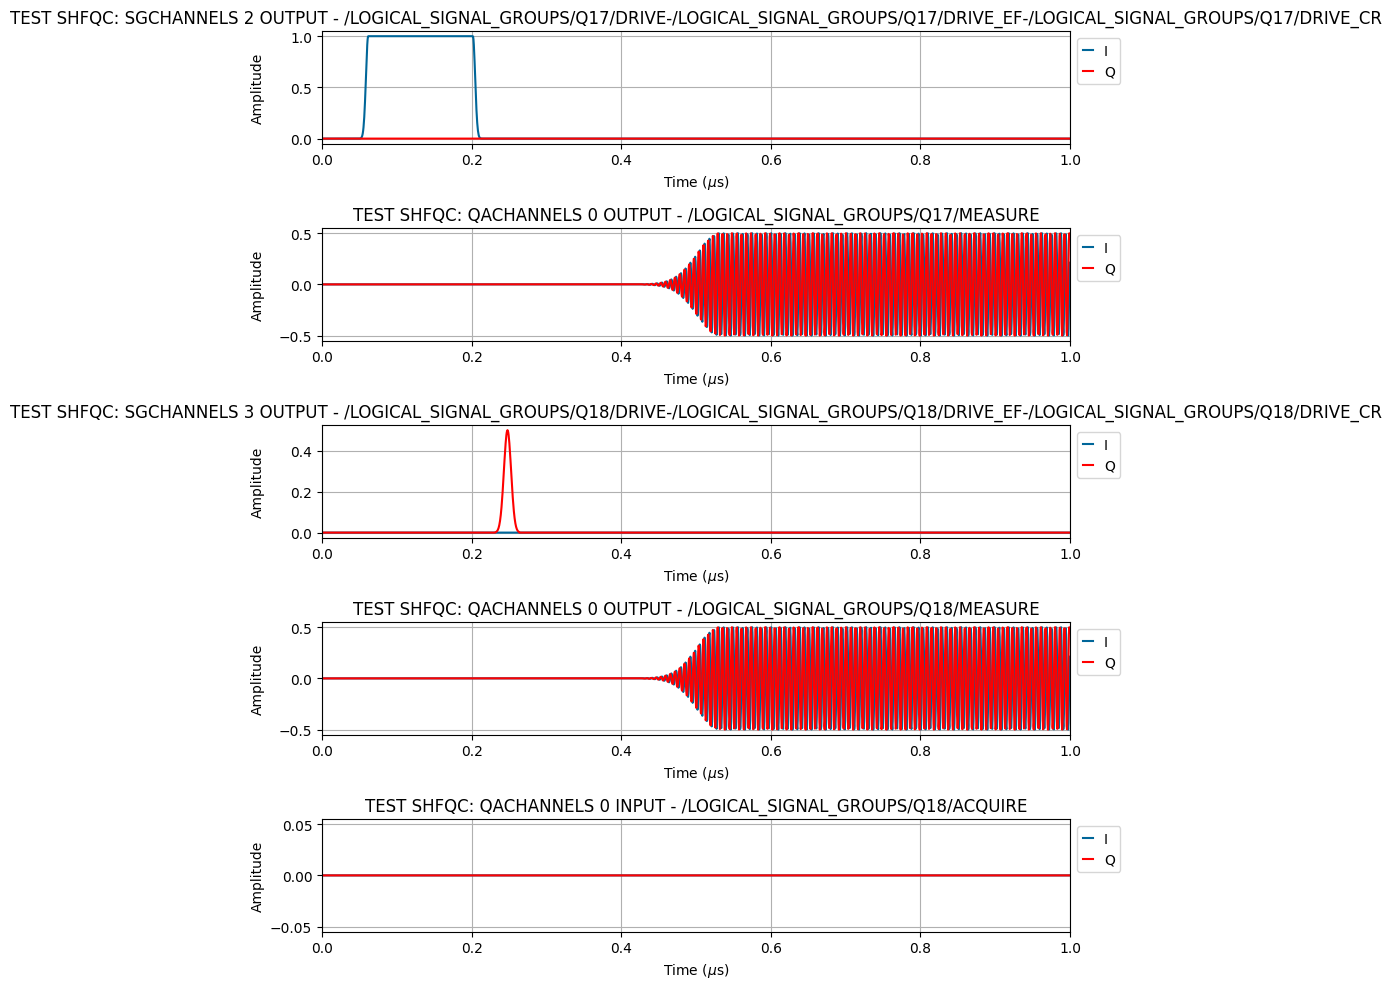

In [12]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation
show_pulse_sheet("first_comp", hamil_tomo_compiled, interactive=True)
plot_simulation(hamil_tomo_compiled, length=1e-6)

In [13]:
qop=quantum_operations
dcr=qop.direct_cr(ctrl=qubits[2], targ=qubits[3], amplitude=1.0, phase=0.0, length=200e-9)
dcr.play_after

# Save Qubit Parameters

In [14]:
# from krisszi_core.contrib.jsahn.helper import load_qubit_parameters, save_qubit_parameters
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters", filename="sleep")

In [15]:
for signal in qubits[2].experiment_signals():
    print(signal.uid)

/logical_signal_groups/q17/drive
/logical_signal_groups/q17/drive_ef
/logical_signal_groups/q17/drive_cr
/logical_signal_groups/q17/measure
/logical_signal_groups/q17/acquire


In [16]:
from laboneq.simple import dsl
from laboneq.simple import SweepParameter

sweep_par = SweepParameter(values=np.array([0,1,2]))   



with dsl.match() as a:
    print(a)
    print(a.uid)


with dsl.sweep(parameter=sweep_par) as b:
    print(b)
    print(b.uid)
    with dsl.match() as a:
        print(a)
        print(a.uid)
        print(b)
print(b)
    

Match(
│   uid='__unnamed_0',
│   name='unnamed',
│   alignment=SectionAlignment.LEFT,
│   execution_type=None,
│   length=None,
│   play_after=None,
│   children=[],
│   trigger={},
│   on_system_grid=False,
│   handle=None,
│   user_register=None,
│   prng_sample=None,
│   sweep_parameter=None,
│   local=None
)

__unnamed_0
SweepParameter(
│   uid='par8',
│   values=array([0, 1, 2]),
│   axis_name=None,
│   driven_by=None
)

par8
Match(
│   uid='__unnamed_2',
│   name='unnamed',
│   alignment=SectionAlignment.LEFT,
│   execution_type=None,
│   length=None,
│   play_after=None,
│   children=[],
│   trigger={},
│   on_system_grid=False,
│   handle=None,
│   user_register=None,
│   prng_sample=None,
│   sweep_parameter=None,
│   local=None
)

__unnamed_2
SweepParameter(
│   uid='par8',
│   values=array([0, 1, 2]),
│   axis_name=None,
│   driven_by=None
)

SweepParameter(
│   uid='par8',
│   values=array([0, 1, 2]),
│   axis_name=None,
│   driven_by=None
)

